In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# from IPython.core.display import display, HTML, clear_output
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import sem

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker
from venn import venn, pseudovenn
import seaborn as sns
from matplotlib.collections import PathCollection

from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from addict import Dict
import json


In [10]:
sys.path.append("../")
import plotting as my_plot

sys.path.append("./mean_field_elect/")
import proteomics_functions as prot_fun
# import base_classes
# import morbidelli as m

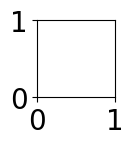

In [11]:
fig, ax = my_plot.instantiate_fig(1, 1)

In [13]:
df_dda = pd.read_csv('./generated_tables/df_master_dda_with_bare_properties.csv')
df_swath = pd.read_csv('./generated_tables/swath_master_df_ppm.csv') # AEX data
df_err = pd.read_csv('./generated_tables/bradford_and_swath_errors.csv')
df_prev = pd.read_csv('./generated_tables/prev_swath_master_df_ppm.csv')
df_prev_sum = pd.read_csv('./generated_tables/prev_elisa_bradford_swath_and_dda_data.csv')

# $N_{DDA}$ vs. $N_{SWATH}$


In [7]:
n_dda = []
n_swath = []

for sample in ['cq_g12', 'cq_eluate', 'hq_g12', 'hq_eluate', 'xq_g12', 'xq_eluate']:
    n_dda.append(len(df_dda[sample][df_dda[sample]]))
    n_swath.append(len(df_swath[sample][df_swath[sample] > 0.0]))

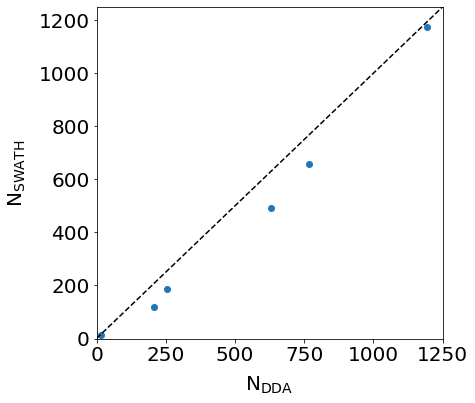

In [8]:
fig, ax = my_plot.instantiate_fig(xlabel=r'$\mathsf{N_{DDA}}$', ylabel=r'$\mathsf{N_{SWATH}}$')
ax.scatter(n_dda, n_swath)
max_val = 1250 # max(n_dda + n_swath)
ax.plot([0, max_val], [0, max_val], 'k--')
ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
my_plot.set_layout(fig, ax)
# plt.savefig('./images/6_n_dda_vs_swath.png', dpi=300, bbox_inches='tight')

# Prepare df_plot

In [73]:
resins = ['cq', 'xq', 'hq']
fracs = ['a5', 'b12', 'd9', 'g12', 'eluate']

resin_names = {'cq':'Capto Q', 'xq':'Poros XQ', 'hq':'Poros 50 HQ'}
frac_names = {'a5':'A5', 'b12':'B12', 'd9':'D9', 'g12':'G12', 'eluate':'Adsorbate'}
percent_loading = {'a5':'5% Loading', 'b12':'28% Loading', 'd9':'53% Loading', 'g12':'99% Loading', 'eluate':'Adsorbate'}

totals = df_swath.sum(axis=0)
df_plot = pd.DataFrame()

i = 0
for resin in resins:
    for frac in fracs:
        df_plot.at[i, 'resin'] = resin
        df_plot.at[i, 'frac'] = frac
        sample = f'{resin}_{frac}'
        df_plot.at[i, 'n_hcps'] = len(df_swath[df_swath[sample] > 0.0])
        df_plot.at[i, 'total_ppm'] = totals[sample]
        i += 1

# SWATH vs. ELISA

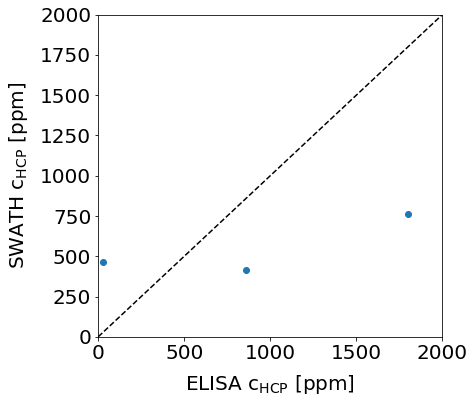

In [10]:
g11_elisa_ppm = [1.80E+03, 8.61E+02, 2.66E+01] # cq, xq, hq
g12_swath_ppm = df_plot[df_plot.frac=='g12'].total_ppm

fig, ax = my_plot.instantiate_fig(xlabel=r'ELISA $\mathsf{c_{HCP}}$ [ppm]', ylabel=r'SWATH $\mathsf{c_{HCP}}$ [ppm]')
ax.scatter(g11_elisa_ppm, g12_swath_ppm)
max_val = 2000
ax.plot([0, max_val], [0, max_val], 'k--')
ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
my_plot.set_layout(fig, ax)
# plt.savefig('./images/6_c_swath_vs_c_elisa.png', dpi=300, bbox_inches='tight')

# $c_{Total}$ vs. $N_{HCPs}$

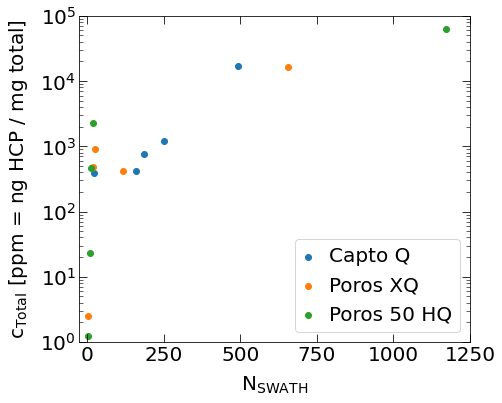

In [11]:
fig, ax = my_plot.instantiate_fig(xlabel=r'$\mathsf{N_{SWATH}}$', ylabel=r'$\mathsf{c_{Total}}$ [ppm = ng HCP / mg total]')
ax.tick_params(axis='both', direction='in', length=8, bottom=True, top=True, left=True, right=True)
ax.tick_params(axis='y', direction='in', which='minor', length=4, left=True, right=True)
ax.set_yscale('log')

for resin in resins:
    df_temp = df_plot[df_plot['resin'] == resin]
    ax.scatter(df_temp['n_hcps'], df_temp['total_ppm'], label=resin_names[resin])
    
ax.set_xlim(-25, 1250)
ax.set_ylim(1, 1e5)
ax.legend(handlelength=0.5, loc='lower right')
# plt.savefig('./images/6_c_total_vs_n_swath.png', dpi=300, bbox_inches='tight')

# $N_{HCPs}$ bar plot

In [12]:
# fig, ax = my_plot.instantiate_fig(x=10, y=6, ylabel=r'$\mathsf{N_{HCPs}}$')
# tick_pos = np.arange(0, 3, 1)
# ticks = ax.set_xticks(tick_pos, ['Capto Q', 'Poros XQ', 'Poros 50 HQ'], rotation=30, ha='right', rotation_mode='anchor')

# width = 1/6
# for i, frac in enumerate(fracs):
#     df_temp = df_plot[df_plot['frac'] == frac]
#     rects = ax.bar(tick_pos + width*(i-2), df_temp['n_hcps'], width=width, label=frac_names[frac])

# legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, handletextpad=0.5, handlelength=1)

# ax.tick_params(axis='both', direction='in', length=8, bottom=True, top=False, left=True, right=True)
# ax.tick_params(axis='y', direction='in', which='minor', length=4, left=True, right=True)
# ax.set_ylim(1, 2000)
# ax.set_yscale('log')
# plt.savefig('./images/6_n_swath_bar_log.png', dpi=300, bbox_inches='tight')

# $c_{Total}$ bar plot

In [13]:
# fig, ax = my_plot.instantiate_fig(x=10, y=6, ylabel=r'$\mathsf{c_{Total}}$ [ppm = ng HCP / mg total]')
# tick_pos = np.arange(0, 3, 1)
# ticks = ax.set_xticks(tick_pos, ['Capto Q', 'Poros XQ', 'Poros 50 HQ'], rotation=30, ha='right', rotation_mode='anchor')

# width = 1/6
# for i, frac in enumerate(fracs):
#     df_temp = df_plot[df_plot['frac'] == frac]
#     rects = ax.bar(tick_pos + width*(i-2), df_temp['total_ppm'], width=width, label=frac_names[frac])

# legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, handletextpad=0.5, handlelength=1)

# ax.tick_params(axis='both', direction='in', length=8, bottom=True, top=False, left=True, right=True)
# ax.tick_params(axis='y', direction='in', which='minor', length=4, left=True, right=True)
# ax.set_ylim(1, 1e5)
# ax.set_yscale('log')
# # plt.savefig('./images/6_c_total_bar_log.png', dpi=300, bbox_inches='tight')

# $N_{HCPs}$ and $c_{Total}$ stacked bar plots

In [74]:
pavin_feed_c = df_prev_sum.at[6, 'swath_ppm']
pavin_feed_c_stdev = df_prev_sum.at[6, 'swath_stdev_ppm']
pavin_feed_c_n = df_prev_sum.at[6, 'n_swath']

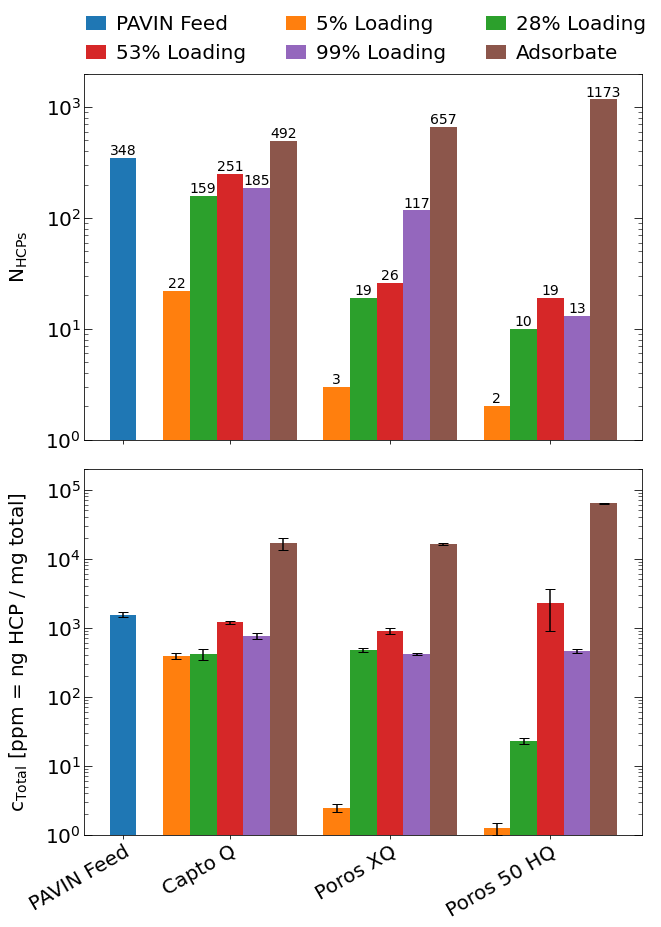

In [85]:
# Setup the figure
fig, ax = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(10, 14, forward=True)
tick_pos = np.arange(0, 3, 1)

ax[0].set_ylabel(r'$\mathsf{N_{HCPs}}$', labelpad=15)
ax[1].set_ylabel(r'$\mathsf{c_{Total}}$ [ppm = ng HCP / mg total]', labelpad=15)

for i in range(2):
    ax[i].tick_params(axis='y', direction='in', which='major', length=8, left=True, right=True)
    ax[i].tick_params(axis='y', direction='in', which='minor', length=4, left=True, right=True)
    ax[i].set_yscale('log')

# Add PAVIN feed data
width = 1/6
rect = ax[0].bar(-4/6, pavin_feed_c_n, width=width, label='PAVIN Feed')
bar_labels = ax[0].bar_label(rect, fontsize=14) # , rotation=90, padding=10

rects_1 = ax[1].bar(-4/6, pavin_feed_c, width=width, label='PAVIN Feed')
err_1 = ax[1].errorbar(-4/6, pavin_feed_c, yerr=pavin_feed_c_stdev*2, fmt=' ', color='black', capsize=5)

# Plot AEX data
width = 1/6
for i, frac in enumerate(fracs):
    df_temp = df_plot[df_plot['frac'] == frac]
    rects = ax[0].bar(tick_pos + width*(i-2), df_temp['n_hcps'], width=width, label=percent_loading[frac])
    bar_labels = ax[0].bar_label(rects, fontsize=14) # , rotation=90, padding=10

    df_temp_err = df_err[df_err['frac'] == frac]
    rects_1 = ax[1].bar(tick_pos + width*(i-2), df_temp['total_ppm'], width=width, label=percent_loading[frac])
    err_1 = ax[1].errorbar(tick_pos + width*(i-2), df_temp['total_ppm'], yerr=df_temp['total_ppm']*df_temp_err['total_rsd']*2, fmt=' ', color='black', capsize=5)

# Set tiks, limits, etc.
tick_pos = [-4/6] + list(tick_pos)
ticks = ax[1].set_xticks(tick_pos, ['PAVIN Feed', 'Capto Q', 'Poros XQ', 'Poros 50 HQ'], rotation=30, ha='right', rotation_mode='anchor')

ax[0].set_ylim(1, 2000)
ax[1].set_ylim(1, 2e5)
plt.subplots_adjust(hspace=0.08)

handles, labels = ax[0].get_legend_handles_labels()
order = [0, 3, 1, 4, 2, 5]
legend = ax[0].legend([handles[i] for i in order], [labels[i] for i in order], loc='lower left', bbox_to_anchor=(-0.03, 0.98), frameon=False, handletextpad=0.5, handlelength=1, ncol=3)

# plt.savefig('./images/6_n_swath_and_c_total_stacked_bar_log.png', dpi=300, bbox_inches='tight')
# plt.savefig('./images/6_n_swath_and_c_total_stacked_bar_log.pdf', bbox_inches='tight')

In [68]:
handles[0]

<BarContainer object of 1 artists>

In [60]:
handles[::2]

[<BarContainer object of 1 artists>,
 <BarContainer object of 3 artists>,
 <BarContainer object of 3 artists>]

In [65]:
vals = [1, 2, 3, 4, 5, 6]
vals[::1]

[1, 2, 3, 4, 5, 6]

# Comparison with the HMW content

In [81]:
df_hmw = pd.read_csv('../2022-07-20_studies_with_raw_HPLC_data/AEX_FT_proteomics_fractions.csv')
df_hmw.rename(columns={'frac':'akta_frac'}, inplace=True)
drop_index = df_hmw[df_hmw['akta_frac'] == '1F05'].index
df_hmw.drop(drop_index, inplace=True)
df_hmw.reset_index(inplace=True, drop=True)

frac_name_map = {'1A05':'a5', '1B12':'b12', '1D09':'d9', '1G12':'g12'}
for i, cont in df_hmw.iterrows():
    frac = frac_name_map[cont['akta_frac']]
    df_hmw.at[i, 'frac'] = frac
    for entry in ['n_hcps', 'total_ppm']:
        df_hmw.at[i, entry] = df_plot.loc[(df_plot['resin'] == cont['resin']) & (df_plot['frac'] == frac), entry].iloc[0]

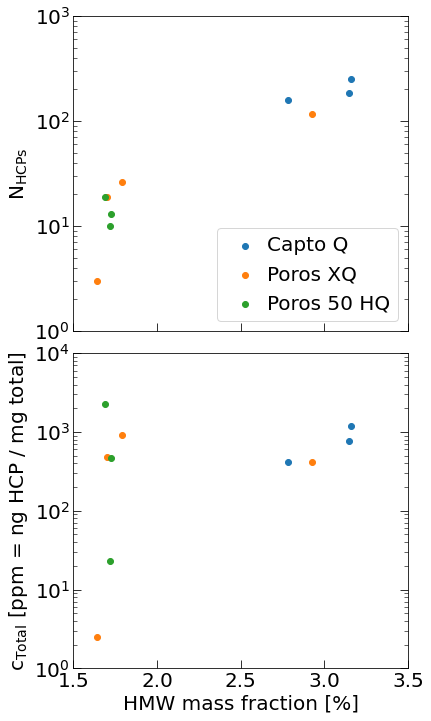

In [86]:
fig, ax = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(6, 12, forward=True)

ax[1].set_xlabel('HMW mass fraction [%]')
ax[0].set_ylabel(r'$\mathsf{N_{HCPs}}$')
ax[1].set_ylabel(r'$\mathsf{c_{Total}}$ [ppm = ng HCP / mg total]')

for i in range(2):
    ax[i].tick_params(axis='both', direction='in', length=8, bottom=True, top=False, left=True, right=True)
    ax[i].tick_params(axis='y', direction='in', which='minor', length=4, left=True, right=True)
    ax[i].set_yscale('log')

for resin in resins:
    df_temp = df_hmw[df_hmw['resin'] == resin]
    ax[0].scatter(df_temp['total_hmw_percent'], df_temp['n_hcps'], label=resin_names[resin])
    ax[1].scatter(df_temp['total_hmw_percent'], df_temp['total_ppm'], label=resin_names[resin])
    
ax[0].set_ylim(1, 1e3)
ax[1].set_ylim(1, 1e4)
ax[0].set_xlim(1.5, 3.5)
plt.subplots_adjust(hspace=0.07)

legend = ax[0].legend(loc='lower right', frameon=True, handletextpad=0.1)
# plt.savefig('./images/6_n_swath_and_c_total_vs_hmw.png', dpi=300, bbox_inches='tight')
# plt.savefig('./images/6_n_swath_and_c_total_vs_hmw.pdf', bbox_inches='tight')

# Master plot

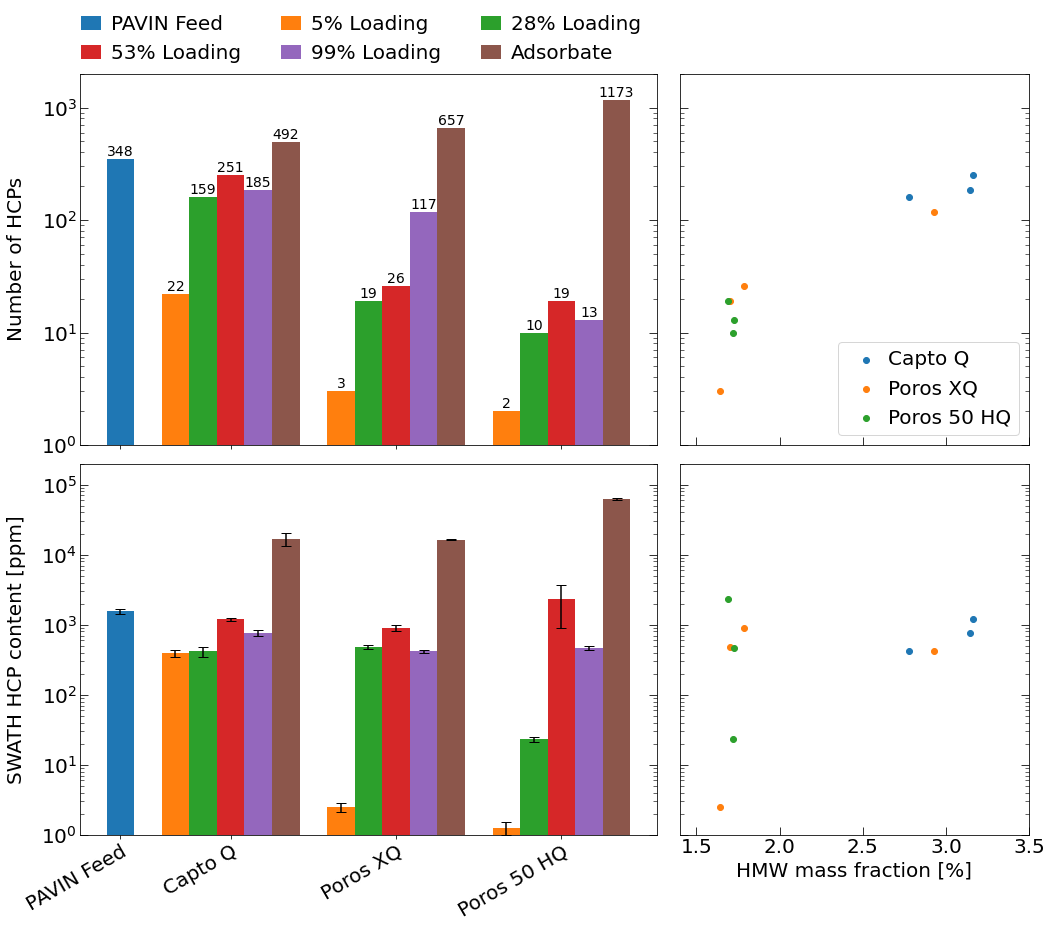

In [96]:
# Setup the figure
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', gridspec_kw={'width_ratios': [1.65, 1]})
fig.set_size_inches(17, 14, forward=True)
tick_pos = np.arange(0, 3, 1)

# First column
ax[0, 0].set_ylabel('Number of HCPs', labelpad=15)
ax[1, 0].set_ylabel('SWATH HCP content [ppm]', labelpad=15)

for i in range(2):
    ax[i, 0].tick_params(axis='y', direction='in', which='major', length=8, left=True, right=True)
    ax[i, 0].tick_params(axis='y', direction='in', which='minor', length=4, left=True, right=True)
    ax[i, 0].set_yscale('log')

# Add PAVIN feed data
width = 1/6
rect = ax[0, 0].bar(-4/6, pavin_feed_c_n, width=width, label='PAVIN Feed')
bar_labels = ax[0, 0].bar_label(rect, fontsize=14) # , rotation=90, padding=10

rects_1 = ax[1, 0].bar(-4/6, pavin_feed_c, width=width, label='PAVIN Feed')
err_1 = ax[1, 0].errorbar(-4/6, pavin_feed_c, yerr=pavin_feed_c_stdev*2, fmt=' ', color='black', capsize=5)

# Plot AEX data
width = 1/6
for i, frac in enumerate(fracs):
    df_temp = df_plot[df_plot['frac'] == frac]
    rects = ax[0, 0].bar(tick_pos + width*(i-2), df_temp['n_hcps'], width=width, label=percent_loading[frac])
    bar_labels = ax[0, 0].bar_label(rects, fontsize=14) # , rotation=90, padding=10

    df_temp_err = df_err[df_err['frac'] == frac]
    rects_1 = ax[1, 0].bar(tick_pos + width*(i-2), df_temp['total_ppm'], width=width, label=percent_loading[frac])
    err_1 = ax[1, 0].errorbar(tick_pos + width*(i-2), df_temp['total_ppm'], yerr=df_temp['total_ppm']*df_temp_err['total_rsd']*2, fmt=' ', color='black', capsize=5)

# Set tiks, limits, etc.
tick_pos = [-4/6] + list(tick_pos)
ticks = ax[1, 0].set_xticks(tick_pos, ['PAVIN Feed', 'Capto Q', 'Poros XQ', 'Poros 50 HQ'], rotation=30, ha='right', rotation_mode='anchor')

ax[0, 0].set_ylim(1, 2000)
ax[1, 0].set_ylim(1, 2e5)
plt.subplots_adjust(hspace=0.08)

handles, labels = ax[0, 0].get_legend_handles_labels()
order = [0, 3, 1, 4, 2, 5]
legend = ax[0, 0].legend([handles[i] for i in order], [labels[i] for i in order], loc='lower left', bbox_to_anchor=(-0.03, 0.98), frameon=False, handletextpad=0.5, handlelength=1, ncol=3)


# Second column
ax[1, 1].set_xlabel('HMW mass fraction [%]')

for i in range(2):
    ax[i, 1].tick_params(axis='both', direction='in', length=8, bottom=True, top=False, left=True, right=True)
    ax[i, 1].tick_params(axis='y', direction='in', which='minor', length=4, left=True, right=True)
    ax[i, 1].set_yscale('log')

for resin in resins:
    df_temp = df_hmw[df_hmw['resin'] == resin]
    ax[0, 1].scatter(df_temp['total_hmw_percent'], df_temp['n_hcps'], label=resin_names[resin])
    ax[1, 1].scatter(df_temp['total_hmw_percent'], df_temp['total_ppm'], label=resin_names[resin])
    
ax[0, 1].set_xlim(1.4, 3.5)
legend = ax[0, 1].legend(loc='lower right', frameon=True, handletextpad=0.1)

plt.subplots_adjust(hspace=0.05, wspace=0.05)

plt.savefig('./images/6_n_swath_and_c_total_stacked_bar_log_and_hmw_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig('./images/6_n_swath_and_c_total_stacked_bar_log_and_hmw_comparison.pdf', bbox_inches='tight')

# c vs. HMW - ELISA comparison

In [148]:
df_hmw_sub = pd.read_csv('../2022-07-20_studies_with_raw_HPLC_data/AEX_FT_150_G11_mass_fracs_all_with_elisa_mod.csv')
df_hmw_sub = df_hmw_sub[df_hmw_sub.flow_cm_h == 150].copy()

for i, cont in df_hmw_sub.iterrows():
    index = df_hmw[(df_hmw['resin'] == cont['resin']) & (df_hmw['frac'] == 'g12')].index
    assert len(index) == 1
    index = index[0]
    df_hmw.at[index, 'elisa_ppm'] = cont['elisa_ppm']

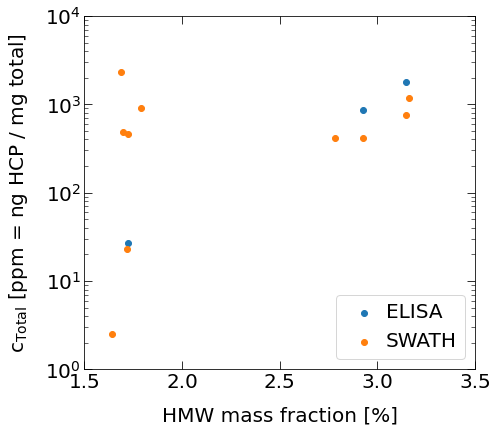

In [160]:
fig, ax = my_plot.instantiate_fig(x=7, y=6.5, ylabel=r'$\mathsf{c_{Total}}$ [ppm = ng HCP / mg total]', xlabel='HMW mass fraction [%]', xpad=15, ypad=15)
ax.tick_params(axis='both', direction='in', length=8, bottom=True, top=True, left=True, right=True)
ax.tick_params(axis='y', direction='in', which='minor', length=4, left=True, right=True)
ax.set_yscale('log')
    
ax.scatter(df_hmw['total_hmw_percent'], df_hmw['elisa_ppm'], label='ELISA')
ax.scatter(df_hmw['total_hmw_percent'], df_hmw['total_ppm'], label='SWATH')

ax.set_ylim(1, 1e4)
ax.set_xlim(1.5, 3.5)

legend = ax.legend(loc='lower right', frameon=True, handletextpad=0.1)
plt.savefig('./images/6_c_elisa_c_swath_vs_hmw.png', dpi=300, bbox_inches='tight')

# Stacked bar plot with HMW content

In [68]:
# for i, cont in df_hmw.iterrows():
#     index = df_plot[(df_plot['resin'] == cont['resin']) & (df_plot['frac'] == cont['frac'])].index
#     assert len(index) == 1
#     index = index[0]
#     df_plot.at[index, 'total_hmw_percent'] = cont['total_hmw_percent']

In [178]:
# fig, ax = plt.subplots(3, 1, sharex=True)
# fig.set_size_inches(10, 18, forward=True)
# tick_pos = np.arange(0, 3, 1)
# ticks = ax[2].set_xticks(tick_pos, ['Capto Q', 'Poros XQ', 'Poros 50 HQ'], rotation=30, ha='right', rotation_mode='anchor')

# ax[0].set_ylabel(r'$\mathsf{N_{HCPs}}$')
# ax[1].set_ylabel(r'$\mathsf{c_{Total}}$ [ppm = ng HCP / mg total]')
# ax[2].set_ylabel('HMW mass fraction [%]')

# for i in range(3):
#     ax[i].tick_params(axis='both', direction='in', length=8, bottom=True, top=False, left=True, right=True)
#     ax[i].tick_params(axis='y', direction='in', which='minor', length=4, left=True, right=True)
# for i in range(2):
#     ax[i].set_yscale('log')

# width = 1/6
# for i, frac in enumerate(fracs):
#     df_temp = df_plot[df_plot['frac'] == frac]
#     rects = ax[0].bar(tick_pos + width*(i-2), df_temp['n_hcps'], width=width, label=percent_loading[frac])
#     bar_labels = ax[0].bar_label(rects, fontsize=16)

#     rects = ax[1].bar(tick_pos + width*(i-2), df_temp['total_ppm'], width=width, label=percent_loading[frac])
#     rects = ax[2].bar(tick_pos + width*(i-2), df_temp['total_hmw_percent'], width=width, label=percent_loading[frac])

# ax[0].set_ylim(1, 2000)
# ax[1].set_ylim(1, 2e5)
# plt.subplots_adjust(hspace=0.08)

# legend = ax[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, handletextpad=0.5, handlelength=1)
# plt.savefig('./images/6_n_swath_and_c_total_and_hmw_stacked_bar.png', dpi=300, bbox_inches='tight')

# $c$ distributions - violin plots

In [37]:
df_all = df_prev.merge(df_swath, how='outer')
df_all = df_all.fillna(0)

df_log = df_all.drop(columns=['accn', 'name'])
df_log = df_log.fillna(0)
df_log = np.log10(df_log)
df_log.replace(-1*np.inf, np.nan, inplace=True)

In [45]:
log10_label = r'$\mathsf{log_{10}\left(c_{HCP} \; [ppm \; = \; ng \; HCP \; / \; mg \; total]\right)}$'

sample = 'pavin_feed'
df_violin = pd.DataFrame()
df_violin[log10_label] = df_log[df_log[sample].notnull()][sample].copy()
df_violin['sample_name'] = 'PAVIN Feed'

for resin in resins:
    for frac in fracs:
        sample = f'{resin}_{frac}'
        label = f'{resin_names[resin]} {percent_loading[frac]}'
        df_temp = pd.DataFrame()
        df_temp[log10_label] = df_log[df_log[sample].notnull()][sample].copy()
        df_temp['sample_name'] = label
        df_violin = pd.concat([df_violin, df_temp], ignore_index=True)

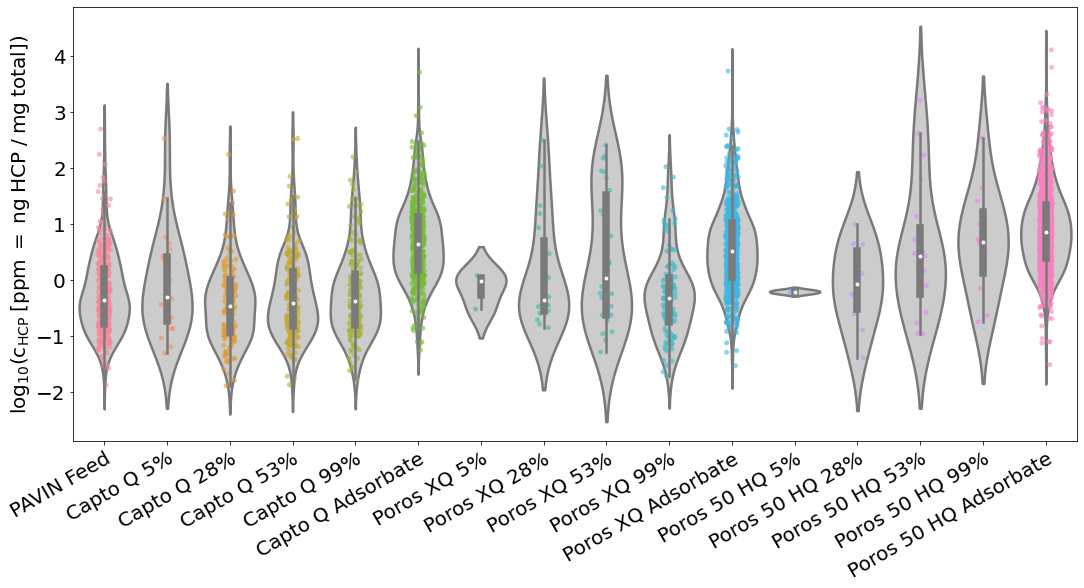

In [63]:
plt.gcf().set_size_inches(18, 8)

xlabel = "sample_name"
ylabel = log10_label
df = df_violin

ax = sns.violinplot(x=xlabel, y=ylabel, data=df, color=".8", linewidth=2.5, scale='width')

for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

strip = sns.stripplot(x=xlabel, y=ylabel, data=df, jitter=True, ax=ax, alpha=0.6)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)

plt.savefig('./images/6_c_HCP_violin.png', dpi=300, bbox_inches='tight')

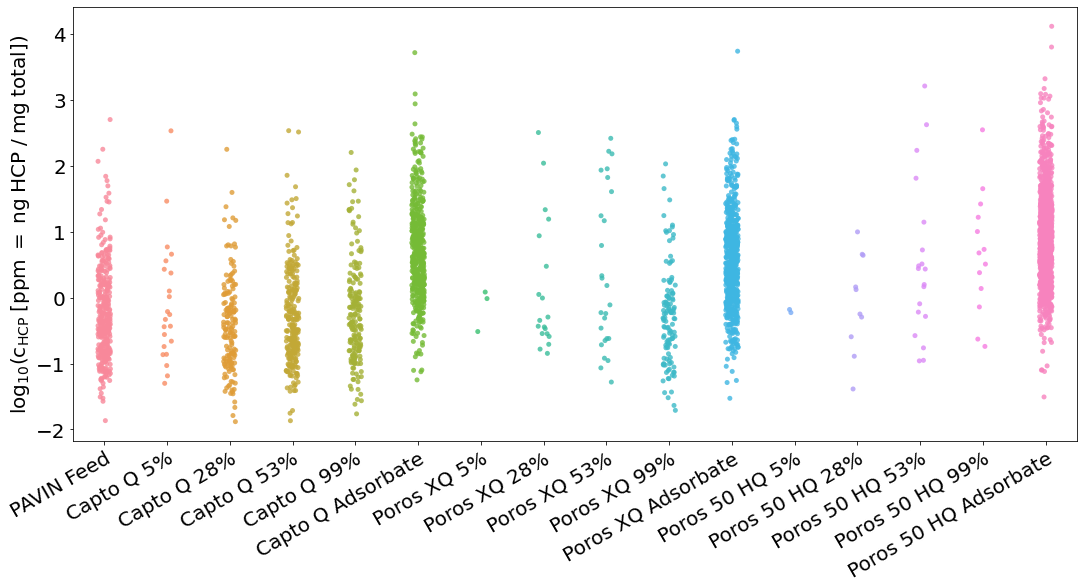

In [64]:
plt.gcf().set_size_inches(18, 8)

xlabel = "sample_name"
ylabel = log10_label
df = df_violin

ax = sns.stripplot(x=xlabel, y=ylabel, data=df, jitter=True, alpha=0.8)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)

plt.savefig('./images/6_c_HCP_strip.png', dpi=300, bbox_inches='tight')

# $N_{HCP} \times \mathsf{Mdn} \left( c_{HCP} \right)$

In [81]:
for i, cont in df_plot.iterrows():
    df_plot.at[i, 'sample'] = f'{cont.resin}_{cont.frac}'
    
df_plot.at[15, 'sample'] = 'pavin_feed'
df_plot.at[15, 'n_hcps'] = pavin_feed_c_n
df_plot.at[15, 'total_ppm'] = pavin_feed_c

In [84]:
for i, cont in df_plot.iterrows():
    sample = cont['sample']
    df_plot.at[i, 'median_c_ppm'] = df_all[df_all[sample] > 0.0][sample].median()

df_plot['n_times_median'] = df_plot['n_hcps'] * df_plot['median_c_ppm']

In [85]:
df_plot

resin    frac  n_hcps     total_ppm      sample  median_c_ppm  \
0     cq      a5    22.0    390.388486       cq_a5      0.509157   
1     cq     b12   159.0    415.430821      cq_b12      0.351275   
2     cq      d9   251.0   1191.621369       cq_d9      0.386313   
3     cq     g12   185.0    762.532922      cq_g12      0.429519   
4     cq  eluate   492.0  16804.692763   cq_eluate      4.489098   
5     xq      a5     3.0      2.480815       xq_a5      0.964092   
6     xq     b12    19.0    479.823924      xq_b12      0.450368   
7     xq      d9    26.0    903.582057       xq_d9      1.147543   
8     xq     g12   117.0    416.047265      xq_g12      0.487346   
9     xq  eluate   657.0  16380.540434   xq_eluate      3.366146   
10    hq      a5     2.0      1.249909       hq_a5      0.624955   
11    hq     b12    10.0     23.040970      hq_b12      0.940888   
12    hq      d9    19.0   2296.693107       hq_d9      2.704169   
13    hq     g12    13.0    464.028839      hq_g12      4.746898   
14    hq  eluate  1173.0  63064.935047   hq_eluate      7.260850   
15   NaN     NaN   348.0   1553.038451  pavin_feed      0.440377   

    n_times_median  
0        11.201459  
1        55.852686  
2        96.964455  
3        79.461015  
4      2208.636271  
5         2.892277  
6         8.556987  
7        29.836118  
8        57.019485  
9      2211.558155  
10        1.249909  
11        9.408881  
12       51.379210  
13       61.709672  
14     8516.977091  
15      153.251222

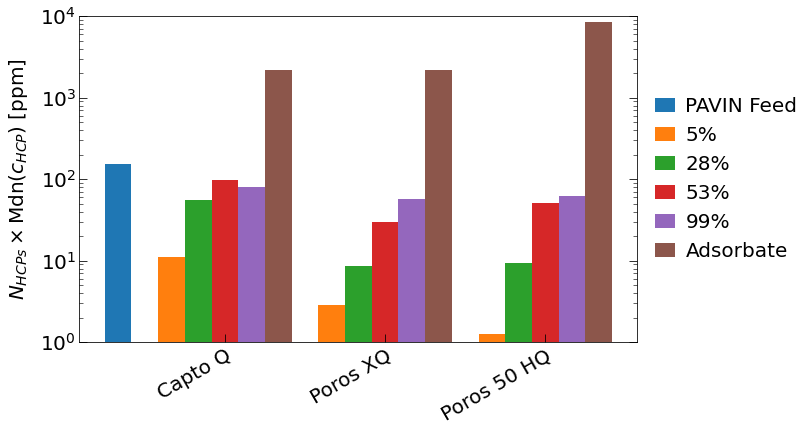

In [92]:
fig, ax = my_plot.instantiate_fig(x=10, y=6, ylabel=r'$N_{HCPs} \times \mathsf{Mdn} \left( c_{HCP} \right)$ [ppm]')
tick_pos = np.arange(0, 3, 1)
ticks = ax.set_xticks(tick_pos, ['Capto Q', 'Poros XQ', 'Poros 50 HQ'], rotation=30, ha='right', rotation_mode='anchor')

# Add PAVIN feed data
rects_1 = ax.bar(-4/6, df_plot.at[15, 'n_times_median'], width=width, label='PAVIN Feed')

width = 1/6
for i, frac in enumerate(fracs):
    df_temp = df_plot[df_plot['frac'] == frac]
    rects = ax.bar(tick_pos + width*(i-2), df_temp['n_times_median'], width=width, label=percent_loading[frac])

legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, handletextpad=0.5, handlelength=1)

ax.tick_params(axis='both', direction='in', length=8, bottom=True, top=False, left=True, right=True)
ax.tick_params(axis='y', direction='in', which='minor', length=4, left=True, right=True)
ax.set_ylim(1, 1e4)
ax.set_yscale('log')
plt.savefig('./images/6_c_n_hcps_times_median_bar.png', dpi=300, bbox_inches='tight')

# Biophysical property distributions

In [94]:
df_prop = pd.read_csv('./generated_tables/swath_master_df_ppm_with_properties.csv')
df_prev_prop = pd.read_csv('../2022-09-20_sec_proteomics/generated_tables/swath_master_df_ppm_with_properties.csv')

### pI

In [100]:
violin_label = 'Isoelectric point'
prop = 'pI'

sample = 'pavin_feed'
df_violin = pd.DataFrame()
df_violin[violin_label] = df_prev_prop[df_prev_prop[sample] > 0.0][prop].copy()
df_violin['sample_name'] = 'PAVIN Feed'

for resin in resins:
    for frac in fracs:
        sample = f'{resin}_{frac}'
        df_temp = pd.DataFrame()
        df_temp[violin_label] = df_prop[df_prop[sample] > 0.0][prop].copy()
        df_temp['sample_name'] = f'{resin_names[resin]} {percent_loading[frac]}'
        df_violin = pd.concat([df_violin, df_temp], ignore_index=True)

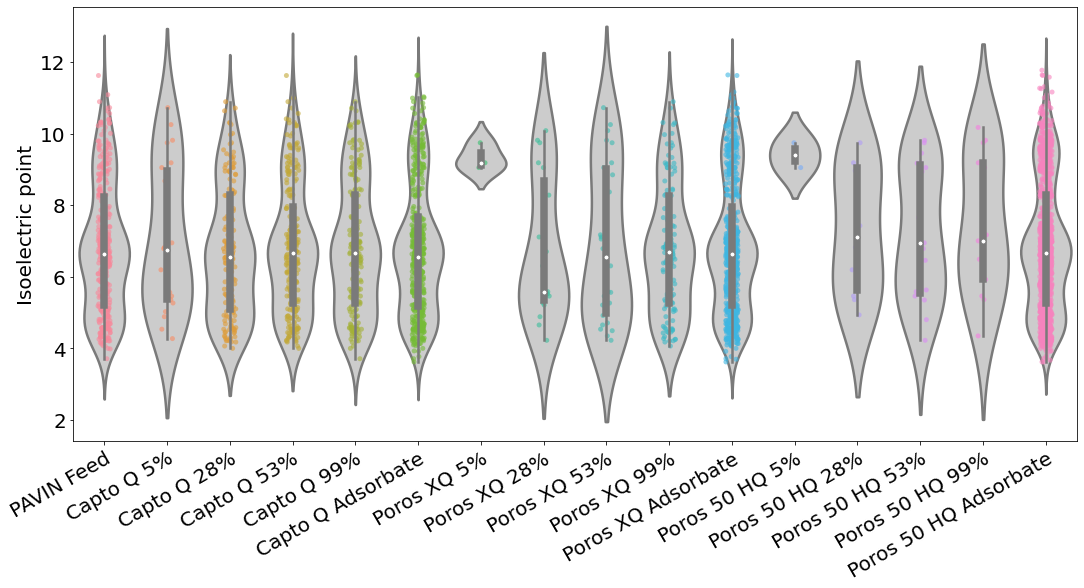

In [104]:
plt.gcf().set_size_inches(18, 8)

xlabel = "sample_name"
ylabel = violin_label
df = df_violin

ax = sns.violinplot(x=xlabel, y=ylabel, data=df, color=".8", linewidth=2.5, scale='width')

for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

strip = sns.stripplot(x=xlabel, y=ylabel, data=df, jitter=True, ax=ax, alpha=0.6)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)

plt.savefig('./images/6_pI_violin.png', dpi=300, bbox_inches='tight')

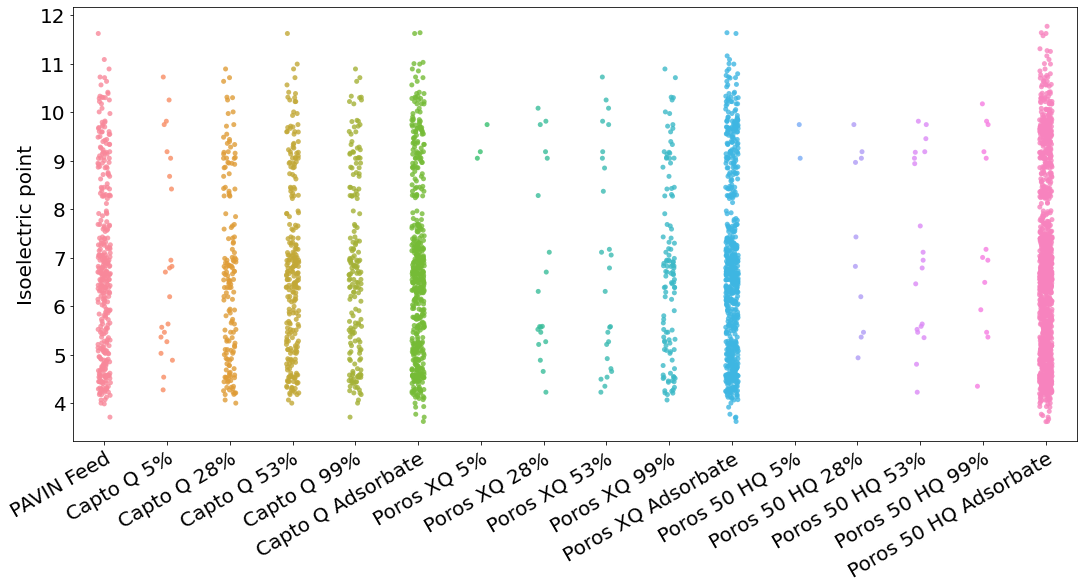

In [105]:
plt.gcf().set_size_inches(18, 8)

xlabel = "sample_name"
ylabel = violin_label
df = df_violin

ax = sns.stripplot(x=xlabel, y=ylabel, data=df, jitter=True, alpha=0.8)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)

plt.savefig('./images/6_pI_strip.png', dpi=300, bbox_inches='tight')

### Mass

In [109]:
violin_label = 'Molecular mass [kDa]'
prop = 'mass'

sample = 'pavin_feed'
df_violin = pd.DataFrame()
df_violin[violin_label] = df_prev_prop[df_prev_prop[sample] > 0.0][prop].copy()
df_violin['sample_name'] = 'PAVIN Feed'

for resin in resins:
    for frac in fracs:
        sample = f'{resin}_{frac}'
        df_temp = pd.DataFrame()
        df_temp[violin_label] = df_prop[df_prop[sample] > 0.0][prop].copy()
        df_temp['sample_name'] = f'{resin_names[resin]} {percent_loading[frac]}'
        df_violin = pd.concat([df_violin, df_temp], ignore_index=True)
        
df_violin[violin_label] *= 1e-3

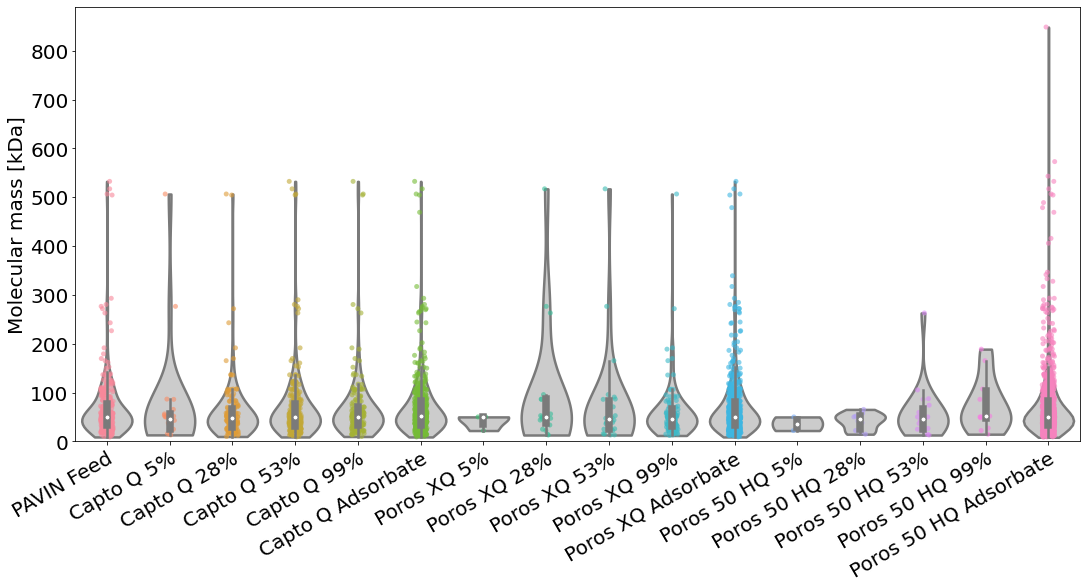

In [110]:
plt.gcf().set_size_inches(18, 8)

xlabel = "sample_name"
ylabel = violin_label
df = df_violin

ax = sns.violinplot(x=xlabel, y=ylabel, data=df, color=".8", linewidth=2.5, scale='width', cut=0)

for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

strip = sns.stripplot(x=xlabel, y=ylabel, data=df, jitter=True, ax=ax, alpha=0.6)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)
ax.set_ylim(0, None)

plt.savefig('./images/6_mass_violin.png', dpi=300, bbox_inches='tight')

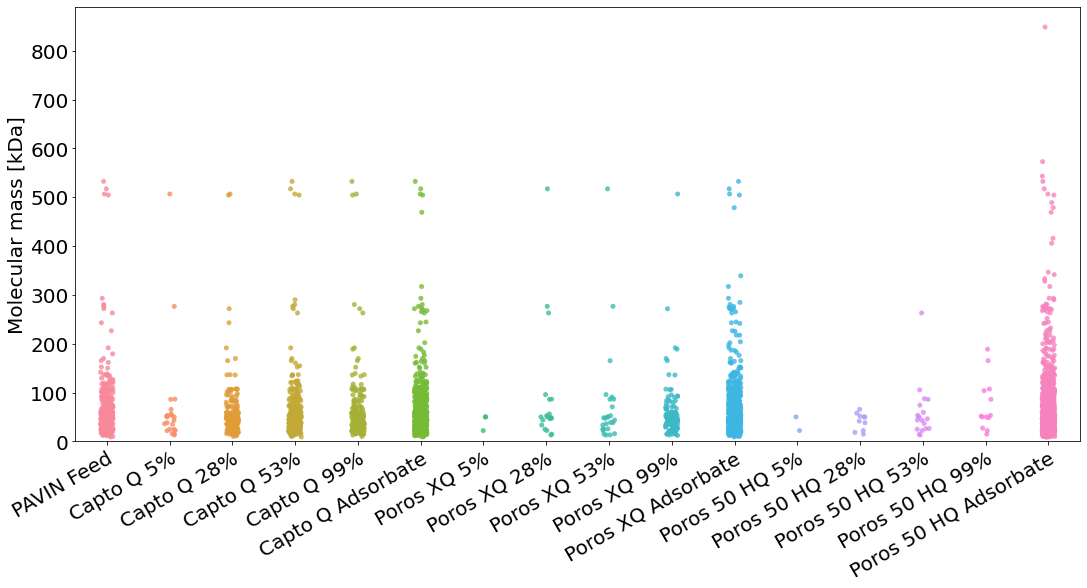

In [111]:
plt.gcf().set_size_inches(18, 8)

xlabel = "sample_name"
ylabel = violin_label
df = df_violin

ax = sns.stripplot(x=xlabel, y=ylabel, data=df, jitter=True, alpha=0.8)
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right", rotation_mode='anchor')
hide = ax.set(xlabel=None)
ax.set_ylim(0, None)

plt.savefig('./images/6_mass_strip.png', dpi=300, bbox_inches='tight')